In [444]:
import os
import re

import pyparsing as pp
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser

In [445]:
latest_report = '2021-12-01' # replace with the most recent here
full_data = pd.read_csv(f'../output/oha-data-{latest_report}.csv')

In [446]:
full_data['report_date'].unique()

array(['2021-5-19', '2021-10-27', '2021-08-18', '2021-4-21', '2021-6-30',
       '2021-4-14', '2021-09-01', '2021-5-12', '2021-09-15', '2021-10-13',
       '2021-05-26', '2021-7-28', '2021-5-5', '2021-6-16', '2021-6-23',
       '2021-4-7', '2021-10-20', '2021-6-9', '2021-4-28', '2021-12-01',
       '2021-09-29', '2021-3-31', '2021-10-06', '2021-11-10',
       '2021-08-11', '2021-09-22', '2021-11-03', '2021-11-17',
       '2021-07-21', '2021-09-09', '2021-07-14', '2021-3-24',
       '2021-11-24', '2021-08-04', '2021-3-17', '2021-08-25'],
      dtype=object)

In [447]:
full_data.sort_values(by='workplace_address')

,workplace_address,county,investigation_start_date,most_recent_onset,total_cases,report_date,last_updated
649,"307 Labor, LLC (Servpro of Douglas County) 11...",Douglas,2021-02-26,2021-02-28,17,2021-4-14,"Sunday, April 11"
3872,"307 Labor, LLC (Servpro of Douglas County) 11...",Douglas,2021-02-26,2021-02-28,17,2021-3-24,"Sunday, March 21"
4165,"307 Labor, LLC (Servpro of Douglas County) 11...",Douglas,2021-02-26,2021-02-28,12,2021-3-17,"Sunday, March 14"
2697,"307 Labor, LLC (Servpro of Douglas County) 11...",Douglas,2021-02-26,2021-02-28,17,2021-3-31,"Sunday, March 28"
463,"307 Labor, LLC (Servpro of Douglas County) 11...",Douglas,2021-02-26,2021-02-28,17,2021-4-21,"Sunday, April 18"
...,...,...,...,...,...,...,...
2252,"Withnell Dodge Motor 2650 Commercial St SE, Sa...",Marion,2021-04-12,2021-04-20,10,2021-4-28,"Sunday, April 25"
1080,Women's Health Center of Southern Oregon 1075 ...,Josephine,2021-07-30,2021-08-23,5,2021-09-15,"Sunday, September 12"
3951,Woodburn Nursery and Azaleas 13009 McKee Schoo...,Marion,2021-01-07,2021-02-02,5,2021-3-24,"Sunday, March 21"
2886,"Yamhill County Public Works 2060 NE Lafayette,...",Yamhill,2021-08-19,2021-08-20,7,2021-10-06,"Sunday, October 3"


In [451]:
full_data = full_data.dropna().copy()

full_data['report_date'] = full_data['report_date'].apply(pd.to_datetime)
full_data['investigation_start_date'] = full_data['investigation_start_date'].apply(pd.to_datetime)
full_data['most_recent_onset'] = full_data['most_recent_onset'].apply(pd.to_datetime)
full_data['workplace_address'] = full_data['workplace_address'].apply(lambda s: s.strip())
full_data[full_data['workplace_address'].str.lower().str.contains('amazon')].sort_values(by=['workplace_address','report_date'],ascending=False).to_csv('../output/amazon-covid-reports-all.csv',index=False)

#theoretical new year edge case but won't affect this set
full_data['last_updated'] = full_data['last_updated'] + ", " + full_data['report_date'].dt.year.apply(str)


In [452]:
def fix_bad_report(row):
    if str(row['report_date']) == '2021-10-27':
        row['last_updated'] = '2021-10-24'
    return row

full_data = full_data.apply(fix_bad_report, axis=1)
full_data['last_updated'] = full_data['last_updated'].apply(pd.to_datetime)

## Culmulative COVID19 Count Chart

In [458]:
amz_line_data = full_data[full_data['workplace_address'].str.lower().str.contains('amazon')].sort_values(by=['workplace_address','report_date'],ascending=False)[['workplace_address','total_cases','last_updated']]

In [459]:
amz_line_data['warehouse'] = amz_line_data['workplace_address'].apply(lambda s: s.split(' ')[1])

### Chart Preview

In [460]:
amz_line_data

,workplace_address,total_cases,last_updated,warehouse
1923,"Amazon UOR2 5015 NW Front Ave, Portland, OR 97210",7,2021-04-04,UOR2
2716,"Amazon UOR2 5015 NW Front Ave, Portland, OR 97210",7,2021-03-28,UOR2
3940,"Amazon UOR2 5015 NW Front Ave, Portland, OR 97210",7,2021-03-21,UOR2
4235,"Amazon UOR2 5015 NW Front Ave, Portland, OR 97210",7,2021-03-14,UOR2
2335,"Amazon Troutdale 1250 NW Swigert Rd, Troutdale...",402,2021-11-28,Troutdale
...,...,...,...,...
580,"Amazon Aumsville 4775 Depot Ct SE, Salem, OR 9...",144,2021-04-11,Aumsville
1835,"Amazon Aumsville 4775 Depot Ct SE, Salem, OR 9...",143,2021-04-04,Aumsville
2630,"Amazon Aumsville 4775 Depot Ct SE, Salem, OR 9...",142,2021-03-28,Aumsville
3854,"Amazon Aumsville 4775 Depot Ct SE, Salem, OR 9...",138,2021-03-21,Aumsville


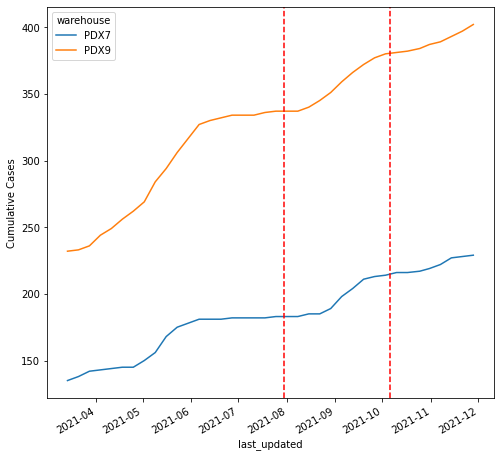

In [480]:
chart_data = amz_line_data.pivot(index='last_updated',columns='warehouse',values='total_cases')[['Aumsville','Troutdale']]
chart_data.rename(columns={'Aumsville':'PDX7','Troutdale':'PDX9'},inplace=True)
ax = chart_data.plot.line(figsize=(8,8))
ax.axvline("2021-07-30", color="red", linestyle="dashed")
ax.axvline("2021-10-06", color="red", linestyle="dashed")
ax.set_ylabel("Cumulative Cases")
plt.savefig('../output/cumulative-cases-chart.svg')
plt.show()

### Underlying Chart Data

In [481]:
chart_data.to_csv('../output/cumulative-cases-data.csv')
chart_data

warehouse,PDX7,PDX9
last_updated,,
2021-03-14 00:00:00,135.0,232.0
2021-03-21 00:00:00,138.0,233.0
2021-03-28 00:00:00,142.0,236.0
2021-04-04 00:00:00,143.0,244.0
2021-04-11 00:00:00,144.0,249.0
2021-04-18 00:00:00,145.0,256.0
2021-04-25 00:00:00,145.0,262.0
2021-05-02 00:00:00,150.0,269.0
2021-05-09 00:00:00,156.0,284.0


## Longest Outbreak Chart

In [482]:
full_data['outbreak_length'] = full_data['most_recent_onset'].sub(full_data['investigation_start_date'])

In [483]:
longest_outbreak_data = full_data.sort_values(by=['outbreak_length','report_date'],ascending=False)

In [484]:
longest_outbreak_data = longest_outbreak_data.dropna().drop_duplicates(subset=['workplace_address','investigation_start_date']).head(10).copy()

In [485]:
longest_outbreak_data.rename(columns={'total_cases': 'Total Cases',
                             'investigation_start_date': 'Investigation Start',
                             'most_recent_onset':'Latest Case Date',
                             'outbreak_length':'Outbreak Length'}, inplace=True)

In [486]:
longest_outbreak_data

,workplace_address,county,Investigation Start,Latest Case Date,Total Cases,report_date,last_updated,Outbreak Length
2335,"Amazon Troutdale 1250 NW Swigert Rd, Troutdale...",Multnomah,2020-05-21,2021-11-22,402,2021-12-01,2021-11-28,550 days
2336,"Amazon Aumsville 4775 Depot Ct SE, Salem, OR 9...",Marion,2020-05-21,2021-11-14,229,2021-12-01,2021-11-28,542 days
2381,"Salem Hospital 890 Oak Street SE, Salem, OR 97301",Marion,2020-05-27,2021-11-01,361,2021-12-01,2021-11-28,523 days
3103,Snake River Correctional Institution 777 Stant...,Malheur,2020-06-24,2021-06-16,639,2021-08-11,2021-08-08,357 days
1673,"Amy's Kitchen 441 W Antelope Rd, White City, O...",Jackson,2020-07-28,2021-04-22,153,2021-06-16,2021-06-13,268 days
2285,"Walmart Distribution Center 2650 US-395, Hermi...",Umatilla,2020-06-30,2021-03-07,124,2021-04-28,2021-04-25,250 days
2338,"Oregon State Hospital (A) 2600 Center St NE, S...",Marion,2021-04-16,2021-11-13,97,2021-12-01,2021-11-28,211 days
2342,"Walmart Distribution Center 2650 US-395, Hermi...",Umatilla,2021-04-26,2021-11-15,70,2021-12-01,2021-11-28,203 days
4188,Eastern Oregon Correctional Institution 2500 W...,Umatilla,2020-07-08,2021-01-25,535,2021-03-17,2021-03-14,201 days
4191,"Oregon State Hospital 2600 Center St NE, Salem...",Marion,2020-07-13,2021-01-25,147,2021-03-17,2021-03-14,196 days


In [469]:
def cut_workplace(s):
    idxs = [i for i in range(0, len(s)) if s[i].isdigit()]
    return s[:idxs[0]]
longest_outbreak_data['Workplace'] = longest_outbreak_data.workplace_address.apply(cut_workplace)

From OHA's [COVID Weekly Reports](https://www.oregon.gov/oha/covid19/Documents/DataReports/Weekly-Outbreak-COVID-19-Report.pdf): 
> An outbreak is considered resolved if no new cases are identified for 28 days after the last case onset.

In [470]:
longest_outbreak_data['Resolved?'] = (longest_outbreak_data['report_date'] - longest_outbreak_data['Latest Case Date']) > timedelta(28)

In [471]:
longest_outbreak_data[['Workplace','Outbreak Length','Total Cases','Resolved?','Investigation Start','Latest Case Date']]

,Workplace,Outbreak Length,Total Cases,Resolved?,Investigation Start,Latest Case Date
2335,Amazon Troutdale,550 days,402,False,2020-05-21,2021-11-22
2336,Amazon Aumsville,542 days,229,False,2020-05-21,2021-11-14
2381,Salem Hospital,523 days,361,True,2020-05-27,2021-11-01
3103,Snake River Correctional Institution,357 days,639,True,2020-06-24,2021-06-16
1673,Amy's Kitchen,268 days,153,True,2020-07-28,2021-04-22
2285,Walmart Distribution Center,250 days,124,True,2020-06-30,2021-03-07
2338,Oregon State Hospital (A),211 days,97,False,2021-04-16,2021-11-13
2342,Walmart Distribution Center,203 days,70,False,2021-04-26,2021-11-15
4188,Eastern Oregon Correctional Institution,201 days,535,True,2020-07-08,2021-01-25
4191,Oregon State Hospital,196 days,147,True,2020-07-13,2021-01-25


In [472]:
longest_outbreak_data[['Workplace','Outbreak Length','Total Cases','Resolved?','Investigation Start','Latest Case Date']].to_csv('../output/longest-outbreaks.csv',index=False)

## Cumulative Case Counts vs. Workforce Sizes

In [474]:
most_recent_counts_all = amz_line_data.pivot(index='last_updated',columns='warehouse',values='total_cases')[['Aumsville','Troutdale']]
most_recent_counts_all.rename(columns={'Aumsville':'PDX7','Troutdale':'PDX9'},inplace=True)
most_recent_counts = most_recent_counts_all.iloc[-1]

PDX7/Aumsville ITA Data

In [475]:
df = pd.read_csv('../data/ITA Data CY 2020 - Sept.csv',encoding = "ISO-8859-1")
amz_stats = df[~(df['company_name'].isna()) & df['company_name'].str.lower().str.contains('amazon')].sort_values(by='total_injuries',ascending=False)
cols = ['id', 'company_name', 'establishment_name', 'ein', 'street_address',
       'city', 'state', 'zip_code',
       'annual_average_employees']
amz_stats[amz_stats['establishment_name'].str.contains('PDX7')][cols]

,id,company_name,establishment_name,ein,street_address,city,state,zip_code,annual_average_employees
276342,1369034,Amazon.com Services LLC,North America Fulfillment Centers (FCs) : PDX7,820544687.0,4775 Depot Ct,Salem,OR,97317,1600
277807,1370531,Amazon,Amazon.com PDX7,NaN,4775 Depot Ct SE,Salem,OR,97317,1557


PDX9/Troutdale ITA Data

In [476]:
amz_stats[amz_stats['establishment_name'].str.contains('PDX9')][cols]

,id,company_name,establishment_name,ein,street_address,city,state,zip_code,annual_average_employees
276343,1369035,Amazon.com Services LLC,North America Fulfillment Centers (FCs) : PDX9,820544687.0,1250 NW Swigert Way,Troutdale,OR,97060,4277


Actual Charting

In [477]:
cumulative_data = {
    'Workforce Size': {'PDX7':1557,'PDX9': 4277},
    f'Cumulative Cases\n(as of {most_recent_counts.name.strftime("%b %d, %Y")})': most_recent_counts
    }
cases_v_workforce_data = pd.DataFrame(cumulative_data)

In [479]:
cases_v_workforce_data

,Workforce Size,"Cumulative Cases\n(as of Nov 28, 2021)"
PDX7,1557,229.0
PDX9,4277,402.0
